In [39]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers

In [40]:
def initiateGenerator(path):
    base_path = path
    print("\nTotal : ", end=" ")
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(batch_size=32, directory=base_path+"/"+"train")

    train_datagen = ImageDataGenerator()

    print("\nFor Training : ", end=" ")
    train_generator = train_datagen.flow_from_directory(
        base_path+"/"+"train",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', subset='training')

    print("\nFor Val : ", end=" ")
    valid_datagen = ImageDataGenerator()
    validation_generator = valid_datagen.flow_from_directory(
        base_path+"/"+"val",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',shuffle=False)
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(
        base_path+"/"+"test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical', shuffle=False)
    class_names = train_dataset.class_names
    noOfClasses = len(class_names)
    print("\nNo of Classes : ", noOfClasses)
    print("Classes : ", class_names)

    plt.figure(figsize=(10, 10))
    for images, labels in train_dataset.take(1):
        for i in range(noOfClasses):
            ax = plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

    for image_batch, labels_batch in train_dataset:
        print("Image Shape : ",image_batch.shape)
        break
        
    return noOfClasses,class_names, train_generator, validation_generator,test_generator

In [41]:
def initiateNormalize():
    AUTOTUNE = tf.data.AUTOTUNE

    train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_generator.cache().prefetch(buffer_size=AUTOTUNE)
    normalization_layer = layers.Rescaling(1./255)

    normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    image_batch, labels_batch = next(iter(normalized_ds))
    first_image = image_batch[0]
    print(np.min(first_image), np.max(first_image))

In [42]:
def initiateVGG19(noOfClasses):
    modelInput = tf.keras.applications.VGG19(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

def modelSummary(model):
    model.summary()

In [43]:
def initiateDenseNet201(noOfClasses):
    modelInput = tf.keras.applications.DenseNet201(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


In [44]:
def initiateMobileNetV3(noOfClasses):
    modelInput = tf.keras.applications.MobileNetV3Small(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model

In [45]:
def initiateParams(className, model, lr,model_name):
    opt = tf.keras.optimizers.Adam(learning_rate=lr)

    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
    checkpoint = ModelCheckpoint(className + model_name+'.h5', verbose=1, save_best_only=True)
    
    return model, annealer, checkpoint

In [46]:
def modelFit(model, annealer, checkpoint, epochs=20, batchSize = 256):

    history = model.fit(
      train_generator,
      validation_data=validation_generator,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[annealer, checkpoint],
      steps_per_epoch=len(train_generator),
      validation_steps=len(validation_generator)
    )
    
    return history


In [47]:
def plotOutput(history, className, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(3, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    plt.savefig(className + '_graph.png')

In [48]:
def evalModel(model):
    evl = model.evaluate(test_generator)
    acc = evl[1]*100
    msg=f'Accuracy on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc
    
def saveModel(model, className,model_name):
    model.save(className + " - "+model_name+"Final.h5")
    print("Model Saved!")

In [49]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

In [50]:
from sklearn.metrics import recall_score,precision_score,f1_score
def callPlot(model, className, classes):
    y_true = test_generator.classes
    print("True : ", (y_true))

    y_pred = model.predict(test_generator)
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    recall=recall_score(y_true,y_pred)
    p=precision_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred)
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")
    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = classes,
                          title        = className + "Confusion Matrix")

In [51]:
mpath = r'../input/multi-cancer/Dataset'
classPaths = os.listdir(mpath)

IMAGE_SIZE = [224, 224]
img_height = 224
img_width = 224
noOfClasses = 0
gEpochs = 10
lr = 0.001

In [52]:
import pprint
part={}
for c in classPaths:
#     part[c]={'models':{"EfficientNetB7":{"model":None,"accurary":0},
#                     "Densenet201":{"model":None,"accurary":0},
#                     "VGG19":{"model":None,"accurary":0},
#                     "ResnetV2":{"model":None,"accurary":0},
#                     "mobilenetV3":{"model":None,"accurary":0}
#                    },'no_of_classes':0,"ClassNames":None}
    part[c]={'models':{},'no_of_classes':0,"ClassNames":None}

In [53]:
pprint.pprint(part)

{'ALL': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Brain Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Breast Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Cervical Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Kidney Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Lung and Colon Cancer': {'ClassNames': None,
                           'models': {},
                           'no_of_classes': 0},
 'Lymphoma': {'ClassNames': None, 'models': {}, 'no_of_classes': 0},
 'Oral Cancer': {'ClassNames': None, 'models': {}, 'no_of_classes': 0}}


In [54]:
def Ensemble(c):
    y_true = test_generator.classes
    print("True : ", (y_true))
    pred=[]
    for model,obj in part[c]['models'].items():
        pred.append(obj['model'].predict(test_generator)*obj['Accurary'])
    y_pred=pred[0]
    for i in range(1,len(pred)):
        y_pred=y_pred+pred[i]
        
    y_pred = np.argmax(y_pred, axis=1)
    print("Predicted : ", (y_pred))

    conf_mat = confusion_matrix(y_true, y_pred)
    recall=recall_score(y_true,y_pred)
    p=precision_score(y_true, y_pred)
    f1=f1_score(y_true, y_pred)
    print(f"RECALL={recall}")
    print(f"precision={p}")
    print(f"F1 Score{f1}")

    plot_confusion_matrix(cm           = conf_mat,
                          normalize    = False,
                          target_names = part[c]['ClassNames'],
                          title        = c + "Confusion Matrix")

In [55]:
def initiateResNet50V2(noOfClasses):
    modelInput = tf.keras.applications.ResNet50V2(
        input_shape=IMAGE_SIZE + [3],
        include_top=False,
        weights="imagenet"
    )
    
    for layer in modelInput.layers:
        layer.trainable = False
    
    x = Flatten()(modelInput.output)
    prediction = Dense(noOfClasses, activation='softmax')(x)

    model = Model(inputs=modelInput.input, outputs=prediction)
    return model


Total :  Found 7000 files belonging to 2 classes.

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 1500 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.

No of Classes :  2
Classes :  ['kidney_normal', 'kidney_tumor']
Image Shape :  (32, 256, 256, 3)
######################################################
RESULTS FORVGG-19
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.8570 - accuracy: 0.9683
Epoch 1: val_loss improved from inf to 0.42823, saving model to Kidney CancerVGG-19.h5
219/219 [==============================] - 28s 126ms/step - loss: 0.8570 - accuracy: 0.9683 - val_loss: 0.4282 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9977
Epoch 2: val_loss improved from 0.42823 to 0.08657, saving model to Kidney CancerVGG-19.h5
219/219 [==============================] - 27s 122ms/step - loss: 0.0624 - accuracy: 0.9977 - val_loss: 0.

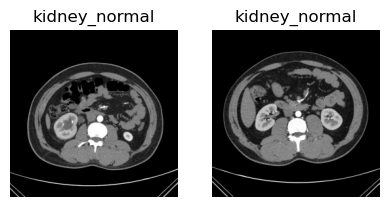

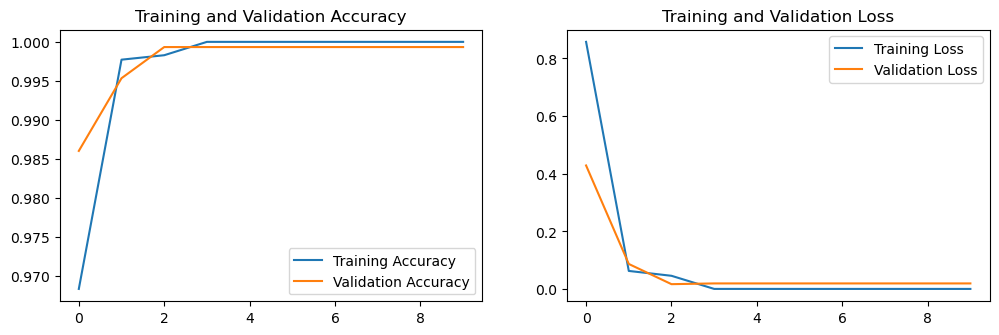

47/47 [==============================] - 5s 100ms/step - loss: 1.9128e-05 - accuracy: 1.0000
Accuracy on the Test Set = 100.00 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 6s 116ms/step
Predicted :  [0 0 0 ... 1 1 1]
RECALL=1.0
precision=1.0
F1 Score1.0


<Figure size 640x480 with 0 Axes>

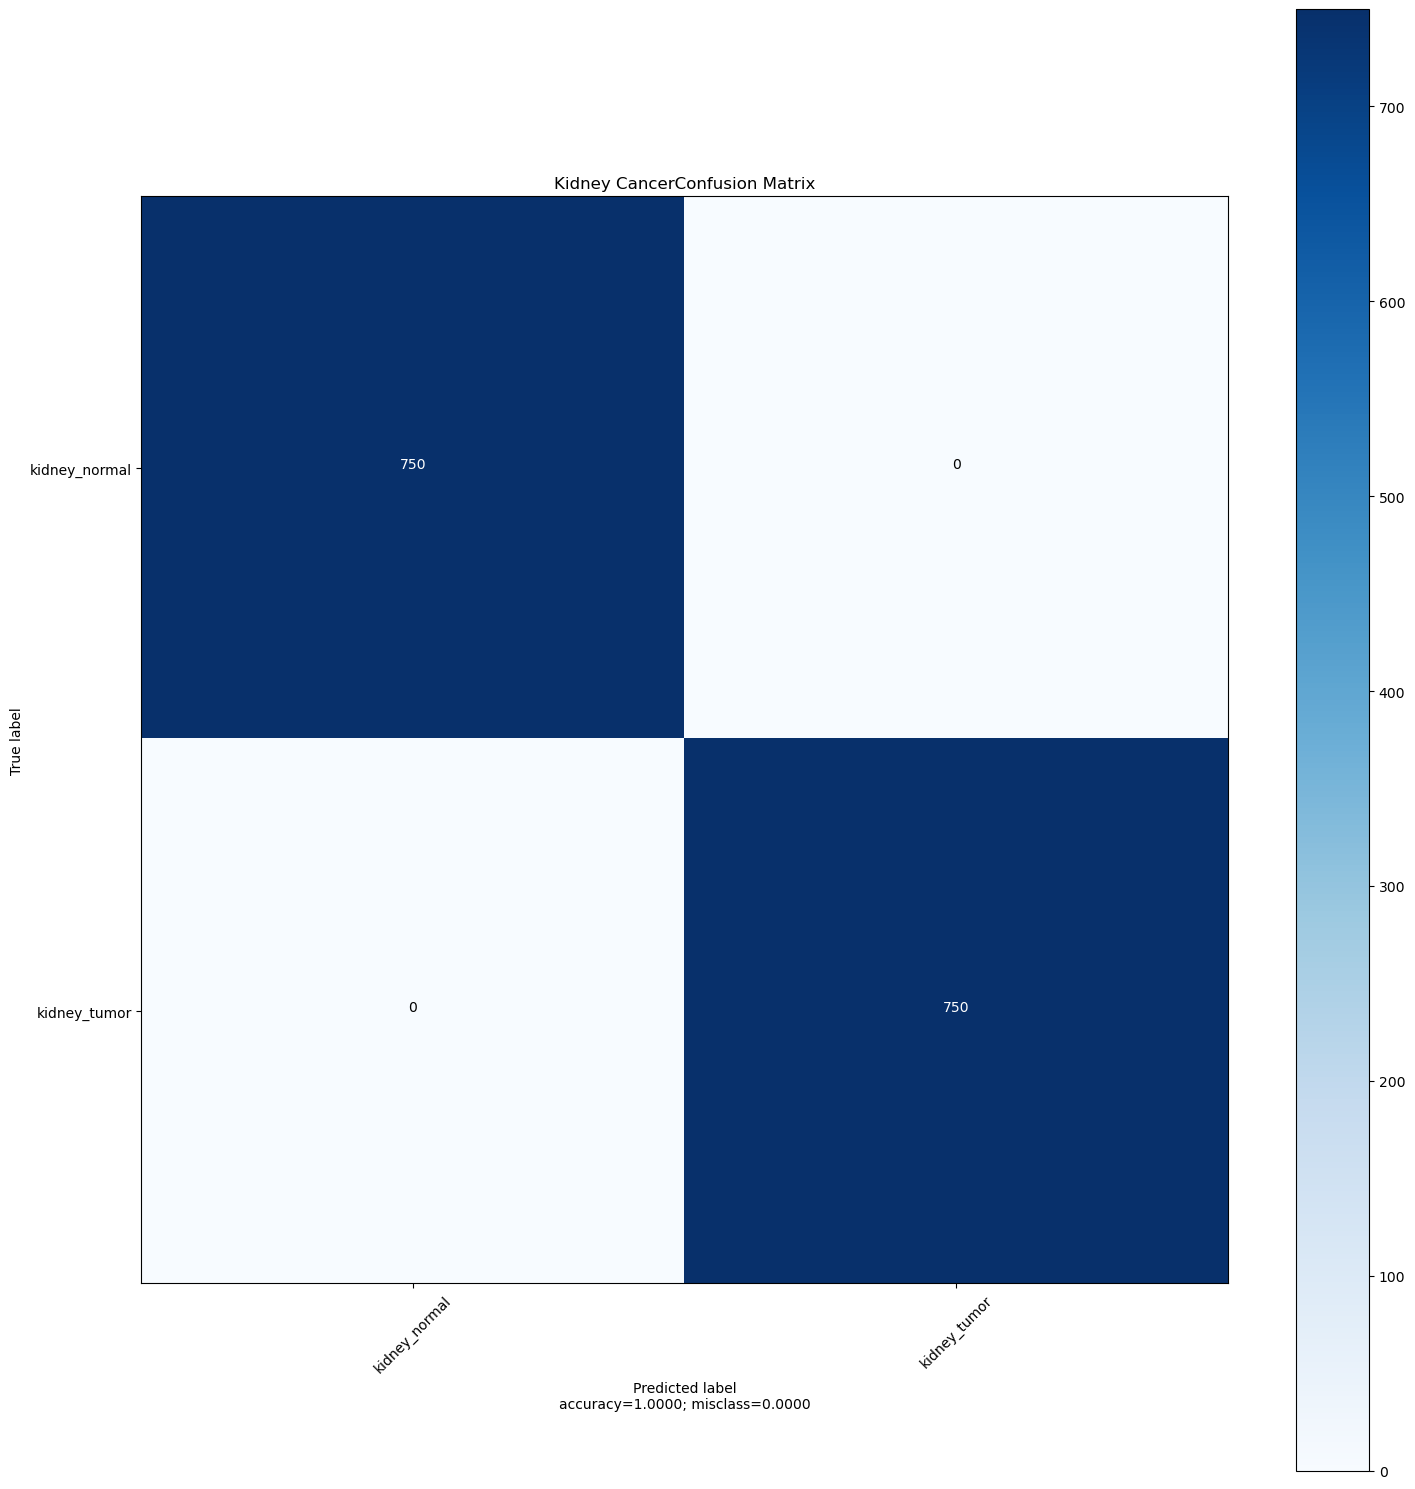

######################################################
RESULTS FORDenseNet201
74836368/74836368 [==============================] - 4s 0us/step
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 6.1187 - accuracy: 0.9224
Epoch 1: val_loss improved from inf to 0.77309, saving model to Kidney CancerDenseNet201.h5
219/219 [==============================] - 51s 173ms/step - loss: 6.1187 - accuracy: 0.9224 - val_loss: 0.7731 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.5236 - accuracy: 0.9769
Epoch 2: val_loss improved from 0.77309 to 0.04514, saving model to Kidney CancerDenseNet201.h5
219/219 [==============================] - 30s 136ms/step - loss: 0.5236 - accuracy: 0.9769 - val_loss: 0.0451 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.9786
Epoch 3: val_loss did not improve from 0.04514
219/219 [==============================]

<Figure size 640x480 with 0 Axes>

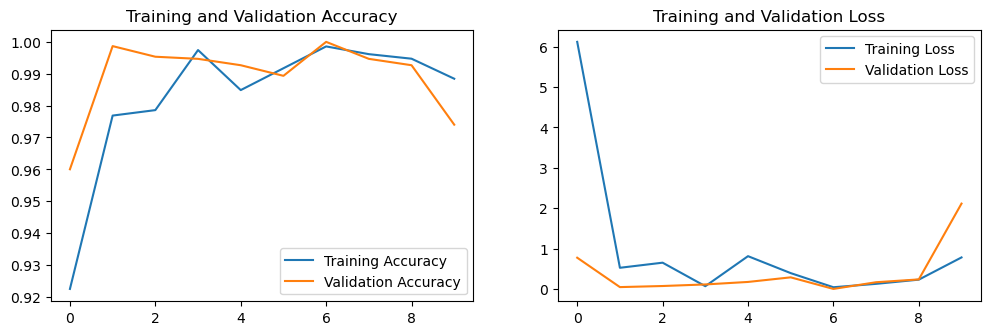

47/47 [==============================] - 5s 113ms/step - loss: 2.2363 - accuracy: 0.9700
Accuracy on the Test Set = 97.00 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 8s 99ms/step
Predicted :  [0 0 0 ... 1 1 1]
RECALL=0.9426666666666667
precision=0.997179125528914
F1 Score0.9691569568197395


<Figure size 640x480 with 0 Axes>

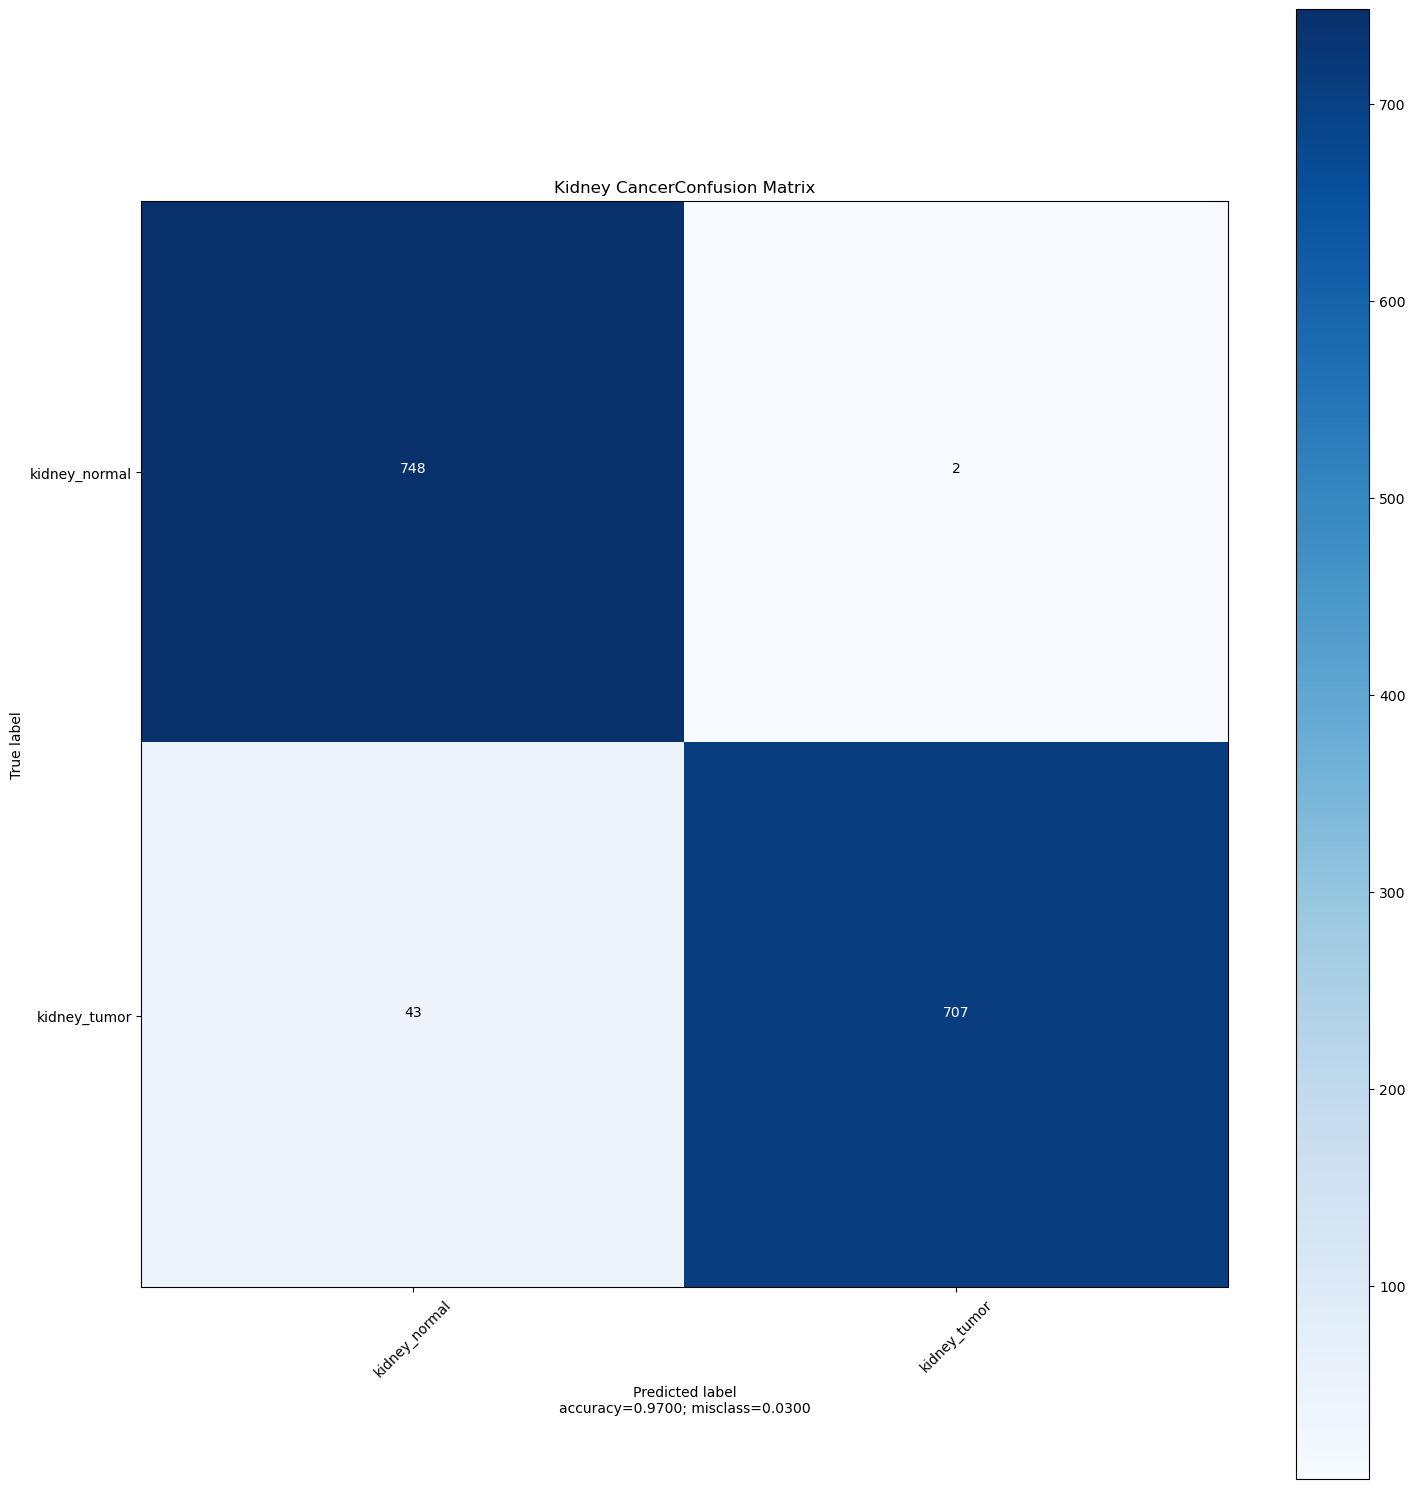

######################################################
RESULTS FORMobileNetV3
4334752/4334752 [==============================] - 1s 0us/step
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 0.3297 - accuracy: 0.9631
Epoch 1: val_loss improved from inf to 0.01403, saving model to Kidney CancerMobileNetV3.h5
219/219 [==============================] - 29s 115ms/step - loss: 0.3297 - accuracy: 0.9631 - val_loss: 0.0140 - val_accuracy: 0.9980 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 0.9996
Epoch 2: val_loss improved from 0.01403 to 0.00281, saving model to Kidney CancerMobileNetV3.h5
219/219 [==============================] - 24s 107ms/step - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 1.1047e-04 - accuracy: 1.0000
Epoch 3: val_loss did not improve from 0.00281
219/219 [=============================

<Figure size 640x480 with 0 Axes>

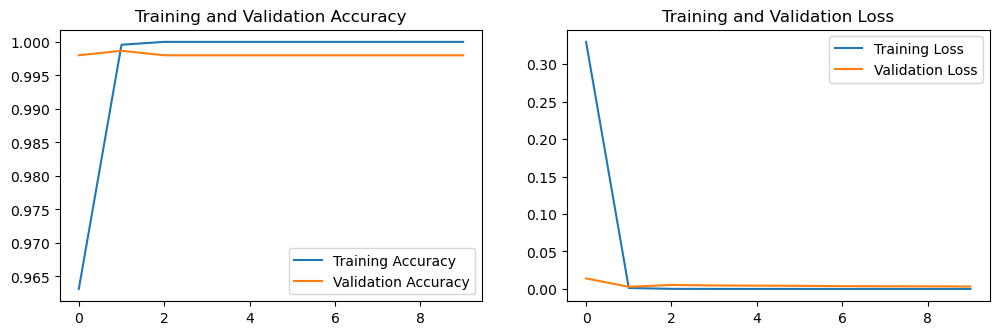

47/47 [==============================] - 5s 96ms/step - loss: 1.9970e-04 - accuracy: 1.0000
Accuracy on the Test Set = 100.00 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 5s 87ms/step
Predicted :  [0 0 0 ... 1 1 1]
RECALL=1.0
precision=1.0
F1 Score1.0


<Figure size 640x480 with 0 Axes>

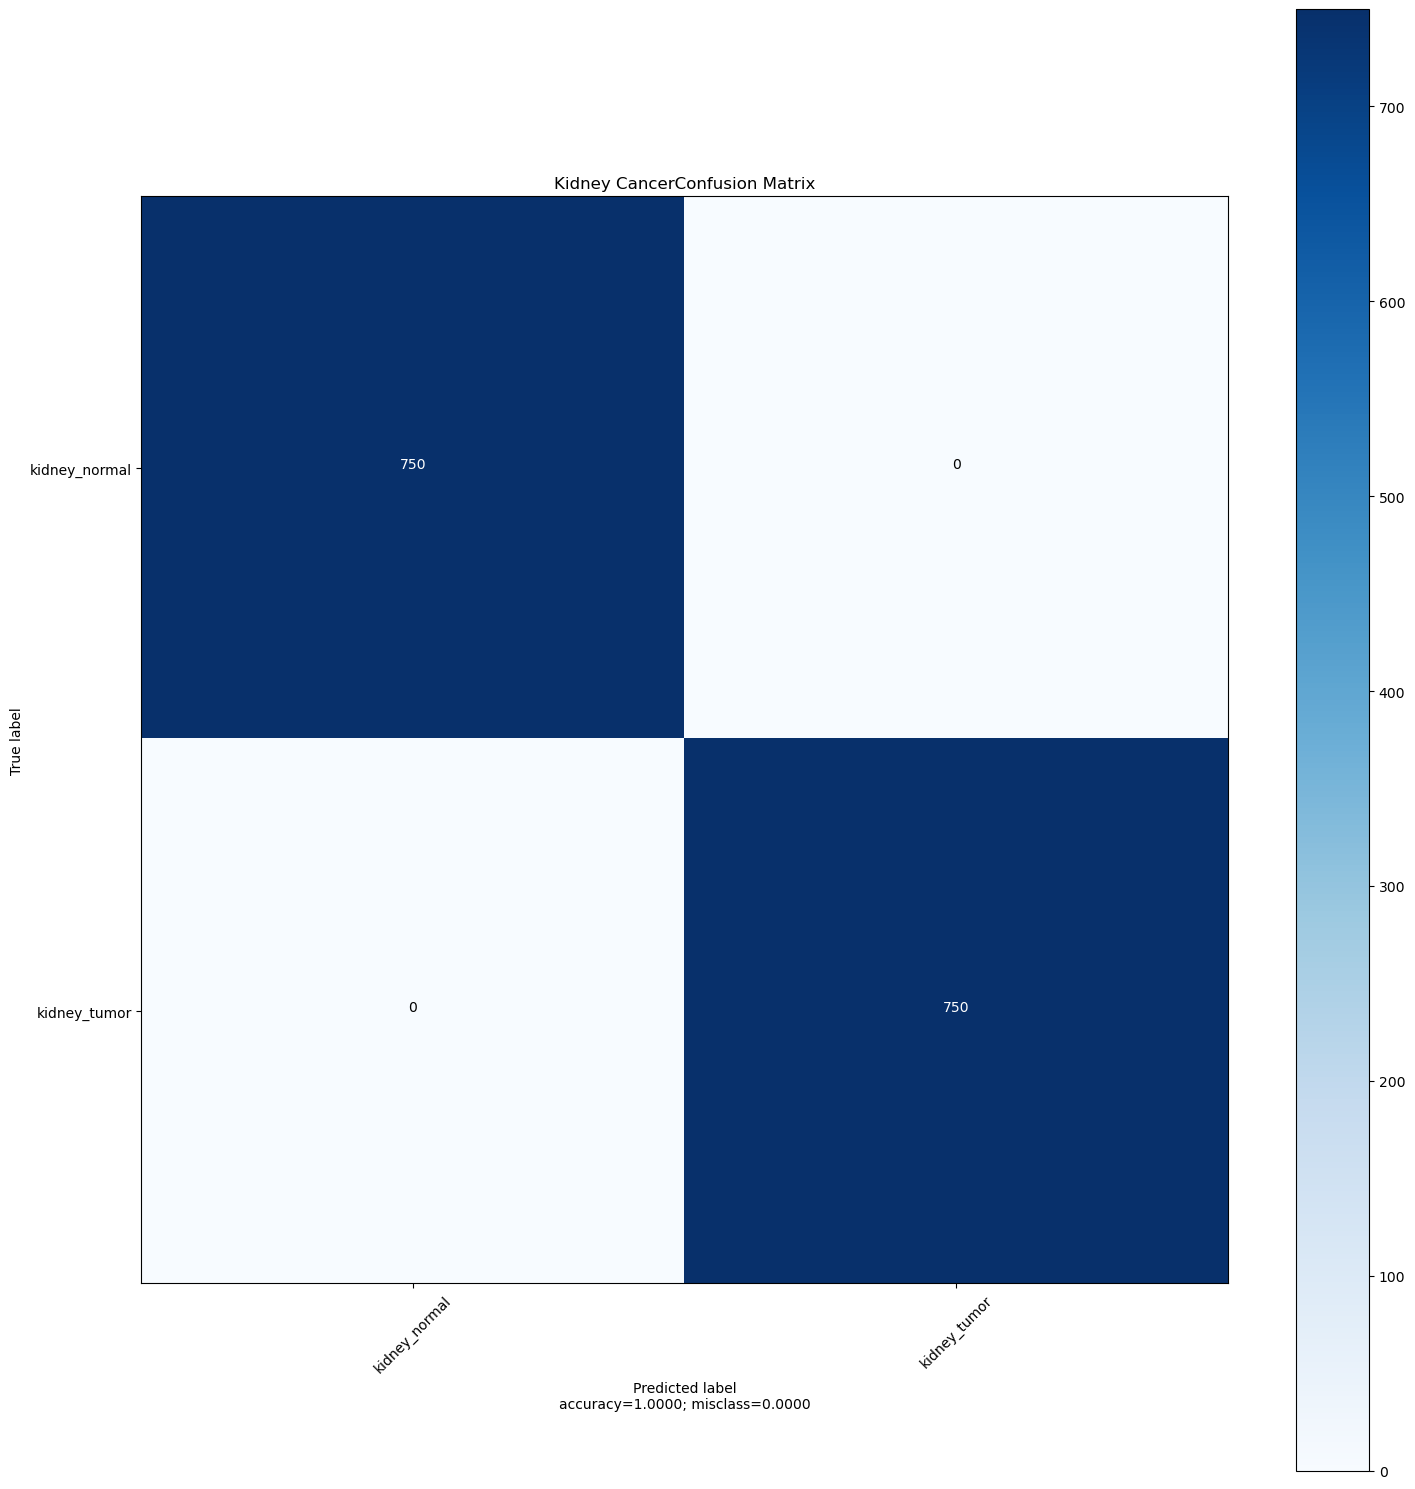

######################################################
RESULTS FORResNet50V2
94668760/94668760 [==============================] - 6s 0us/step
Epoch 1/10
219/219 [==============================] - ETA: 0s - loss: 33.9827 - accuracy: 0.9240
Epoch 1: val_loss improved from inf to 3.14212, saving model to Kidney CancerResNet50V2.h5
219/219 [==============================] - 38s 154ms/step - loss: 33.9827 - accuracy: 0.9240 - val_loss: 3.1421 - val_accuracy: 0.9860 - lr: 0.0010
Epoch 2/10
219/219 [==============================] - ETA: 0s - loss: 2.0106 - accuracy: 0.9876
Epoch 2: val_loss improved from 3.14212 to 0.56315, saving model to Kidney CancerResNet50V2.h5
219/219 [==============================] - 27s 121ms/step - loss: 2.0106 - accuracy: 0.9876 - val_loss: 0.5632 - val_accuracy: 0.9947 - lr: 0.0010
Epoch 3/10
219/219 [==============================] - ETA: 0s - loss: 2.3416 - accuracy: 0.9880
Epoch 3: val_loss did not improve from 0.56315
219/219 [==============================] 

<Figure size 640x480 with 0 Axes>

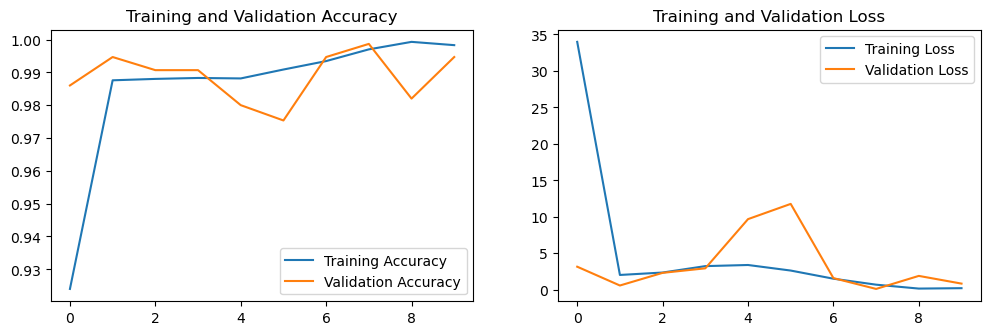

47/47 [==============================] - 5s 99ms/step - loss: 0.9424 - accuracy: 0.9967
Accuracy on the Test Set = 99.67 %
Model Saved!
True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 6s 90ms/step
Predicted :  [0 0 0 ... 1 1 0]
RECALL=0.9933333333333333
precision=1.0
F1 Score0.9966555183946488


<Figure size 640x480 with 0 Axes>

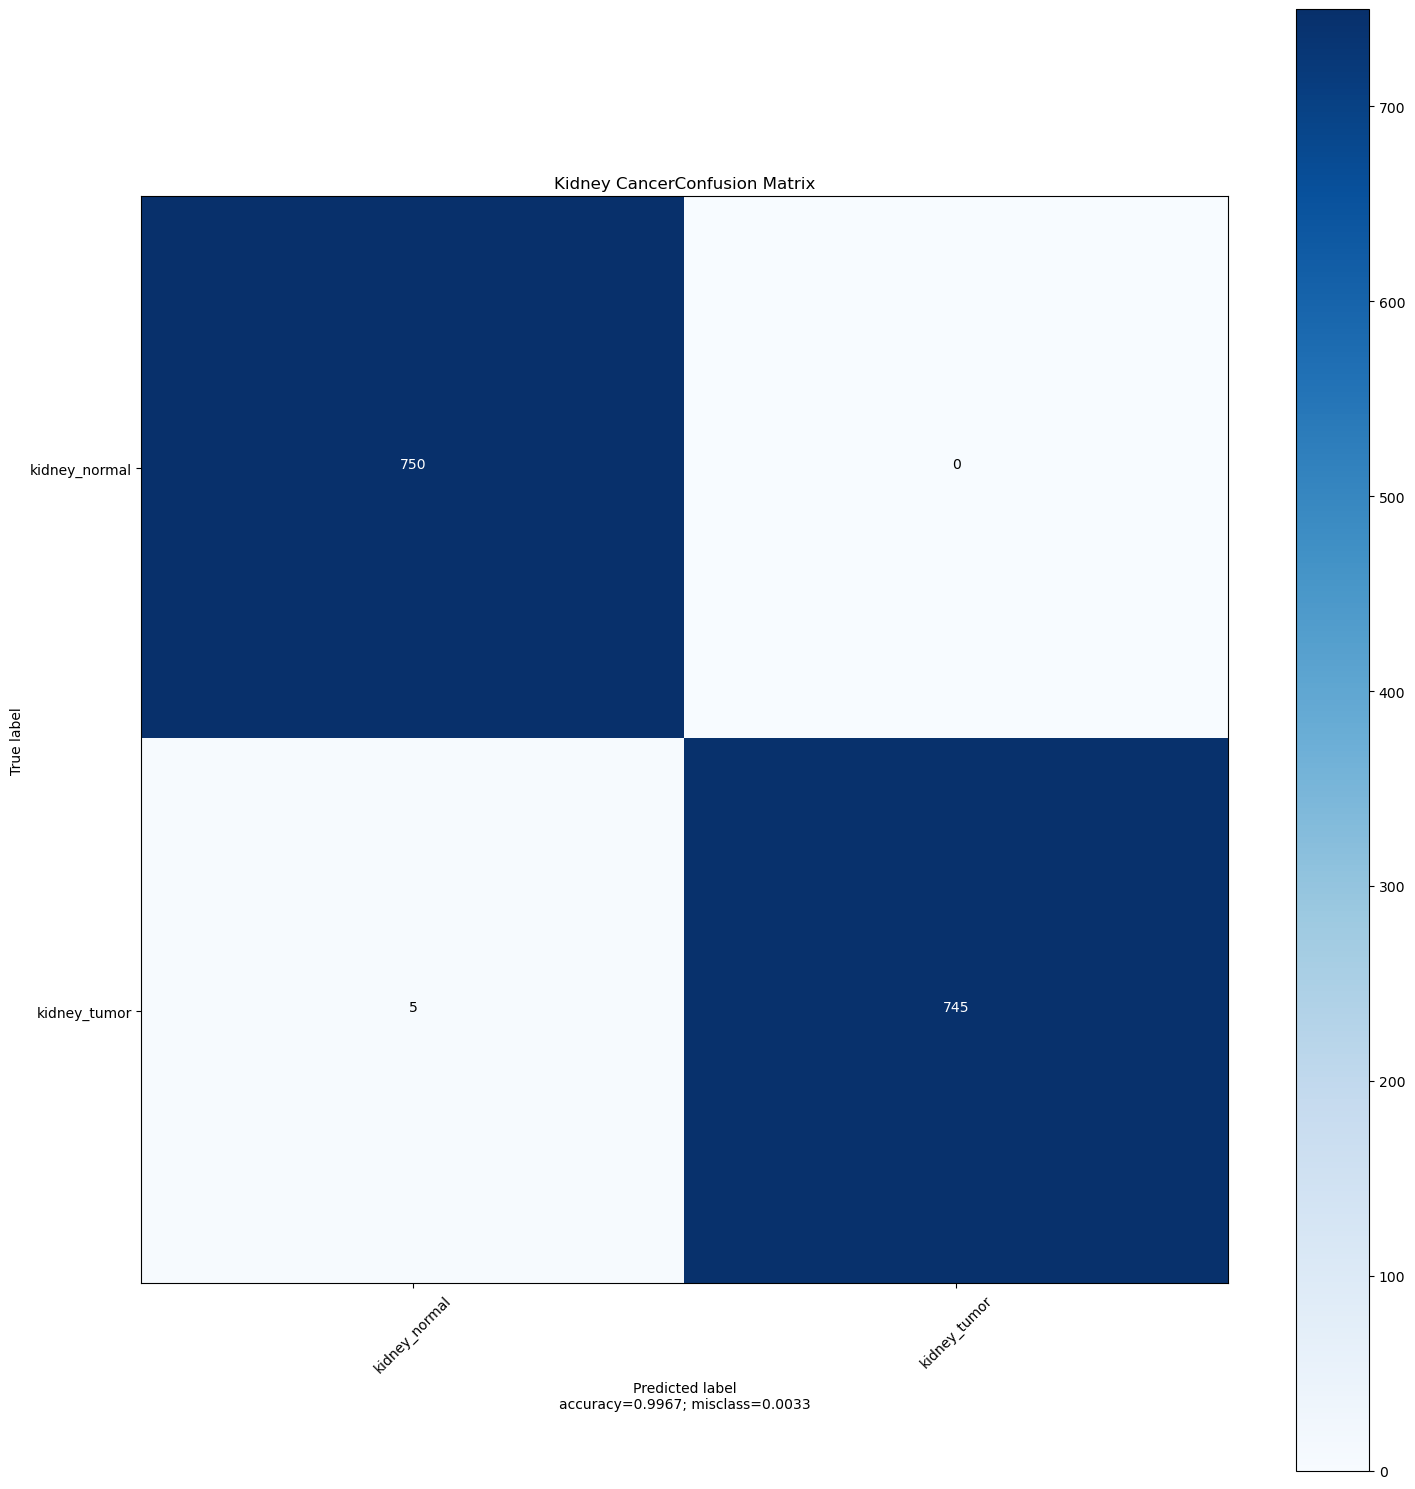

True :  [0 0 0 ... 1 1 1]
47/47 [==============================] - 5s 100ms/step
Predicted :  [0 0 0 ... 1 1 1]
RECALL=1.0
precision=1.0
F1 Score1.0


<Figure size 640x480 with 0 Axes>

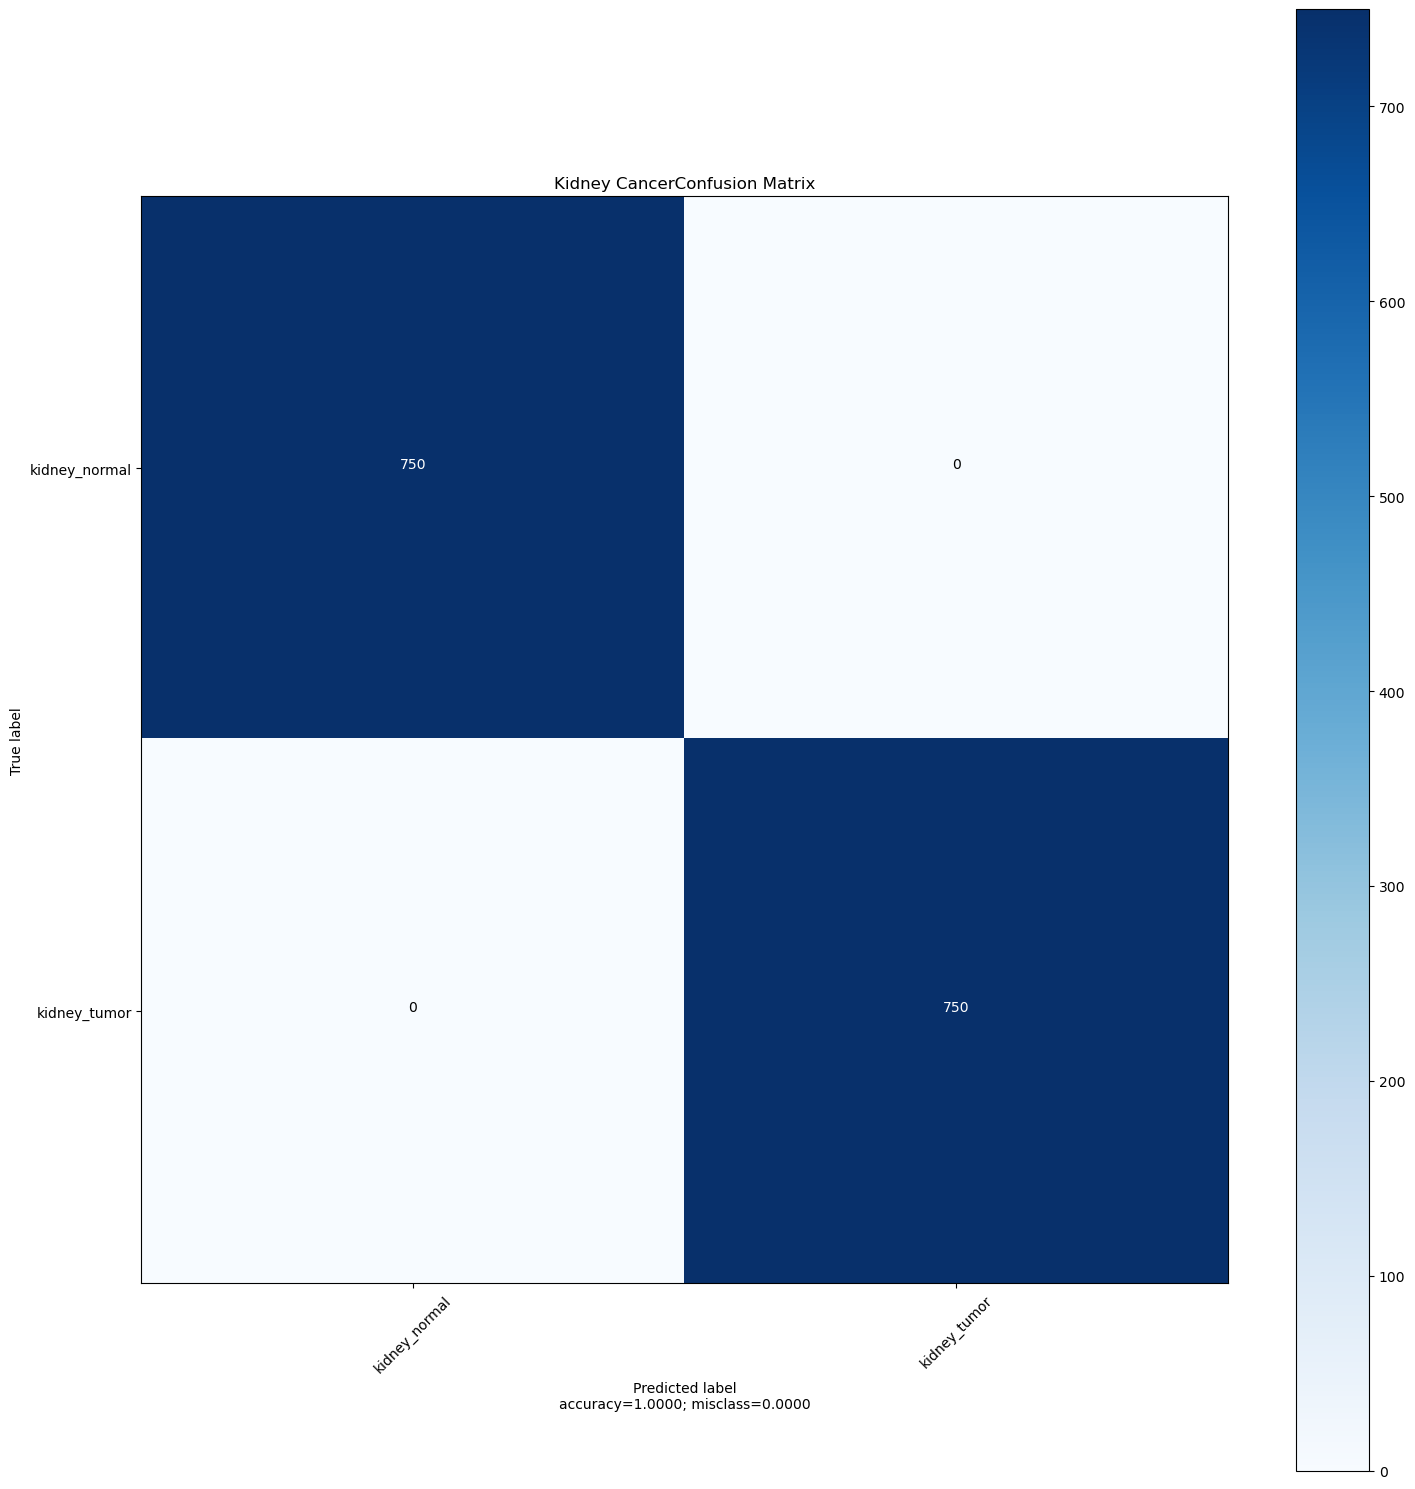

<Figure size 640x480 with 0 Axes>

In [56]:
for c in classPaths[4:5]:
    className = c
#     model_name="VGG-19"
    cpath = os.path.join(mpath, c)
    noOfClasses, class_names, train_generator, validation_generator,test_generator = initiateGenerator(cpath)
    part[c]['ClassNames']=class_names
    
    
    
    model_name="VGG-19"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curVGG19 = initiateVGG19(noOfClasses)
    #modelSummary(curVGG19)
    curVGG19, annealer, checkpoint = initiateParams(className, curVGG19, lr,model_name)
    curHistory = modelFit(curVGG19, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curVGG19)
    
    saveModel(curVGG19, className,model_name)
    part[c]['models']['VGG19']={"model":curVGG19,'Accurary':acc}
    callPlot(curVGG19, className, class_names)
    
    model_name="DenseNet201"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curDenseNet201= initiateDenseNet201(noOfClasses)
    #modelSummary(curDenseNet201)
    curDenseNet201, annealer, checkpoint = initiateParams(className, curDenseNet201, lr,model_name)
    curHistory = modelFit(curDenseNet201, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curDenseNet201)
    saveModel(curDenseNet201, className,model_name)
    part[c]['models']['DenseNet201']={"model":curDenseNet201,'Accurary':acc}
    callPlot(curDenseNet201, className, class_names)
    
    
    
    model_name="MobileNetV3"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curMobileNetV3 = initiateMobileNetV3(noOfClasses)
    #modelSummary(curMobileNetV3)
    curMobileNetV3, annealer, checkpoint = initiateParams(className, curMobileNetV3, lr,model_name)
    curHistory = modelFit(curMobileNetV3, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curMobileNetV3)
    saveModel(curMobileNetV3, className,model_name)
    part[c]['models']['MobileNetV3']={"model":curMobileNetV3,'Accurary':acc}
    callPlot(curMobileNetV3, className, class_names)
    
    model_name="ResNet50V2"
    print("######################################################")
    print(f"RESULTS FOR{model_name}")
    curResNet50V2 = initiateResNet50V2(noOfClasses)
    #modelSummary(curResNet50V2)
    curResNet50V2, annealer, checkpoint = initiateParams(className, curResNet50V2, lr,model_name)
    curHistory = modelFit(curResNet50V2, annealer, checkpoint, epochs=gEpochs, batchSize=256)
    plotOutput(curHistory, className, gEpochs)
    acc=evalModel(curResNet50V2)
    saveModel(curResNet50V2, className,model_name)
    part[c]['models']['ResNet50V2']={"model":curResNet50V2,'Accurary':acc}
    callPlot(curResNet50V2, className, class_names)
     print("######################################################")
    print(f"RESULTS FOR ENSEMBLE")
    Ensemble(c)
    
    
    